<a href="https://colab.research.google.com/github/ouzlaye/Xadrabi-TV/blob/master/Digit_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Generation 🔢

![](https://images.unsplash.com/photo-1502570149819-b2260483d302?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80)

Photo by [Nick Hillier](https://unsplash.com/photos/yD5rv8_WzxA)

---

# A GAN to generate digits

In this exercise, you will be asked to :
- complete the code to create your first GAN
- train a GAN to generate digits based on the MNIST dataset

You should be able to generate new digits by the end of the exercise. This exercise can be run locally, but you can also go for a notebook in Google Colab for example.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from keras.datasets import mnist


Using TensorFlow backend.


## I. Input data

In this GAN example, we're going to use the MNIST dataset. MNIST is a set of handwritten digits. We'll try to generate new digit samples using GANs.

We kindly remind you how to load the data 🙂

In [0]:
(X_train, _), (_, _) = mnist.load_data()

# Some useful variables
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train.shape

(60000, 28, 28)

**Q1**. Rescale the data from -1 to 1 and format the X_train dataset in order to have the proper dimensions

> 🔦 **Hint**: Remember, the MNIST dataset is grayscale so contains only one channel but Keras expects input images to have 3 dimensions even if there is only one channel.

In [0]:
# TODO: Rescale -1 to 1 and format the X_train dataset
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


In [0]:
print(X_train.mean(), X_train.max())

-0.7386798 1.0


**Q2**.Visualize one of the image

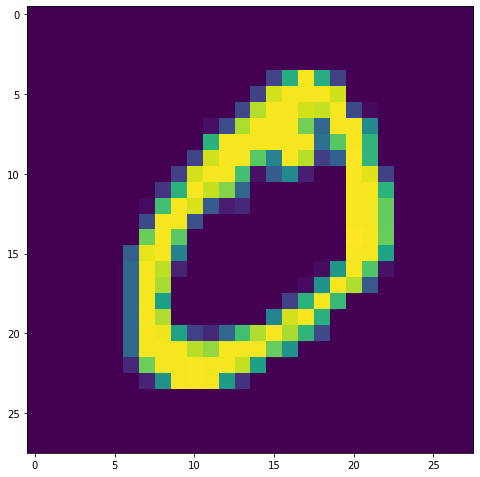

In [0]:
# TODO : Visualize one image
plt.figure(figsize=(8,10))
img = X_train[1].reshape(28,28)
plt.imshow(img)
plt.show()

## II. Build the GAN

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

### a. The Generator

**Q1**. The first step is to build a generator. For the generator, we start with an **input noise shape of size 100**. We then create a sequential model to increase the size of the data up to 1024, before reshaping the data back to the input image shape.

Each layer will be made of:
- A **Dense layer** (sizes 256, 512, 1024 in order)
- A **LeakyRelu activation** with alpha = 0.2
- A **Batch normalization** (momentum = 0.8)

In [0]:
def build_generator():
    # Input Data
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    
    # Create the sequential model
    model = Sequential()

    # Build the first layer
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Second layer
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Third layer
    model.add(Dense(units=1024 ))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    
    # Flatten and reshape
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))


    # Get model summary
    img= model(noise)
    model.summary()

    
    return Model(noise, img)

**Q2**. Compile the Generator and add an Adam optimizer as advised.

In [0]:
# TODO : Compile the generator
my_generator = build_generator() 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

In [0]:
my_generator.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

### b. The Discriminator

**Q3**. Build the discriminator. It takes an input that has the shape of the image. The steps are the following :
- Declare the **Sequential** model
- **Flatten** the images (with input shape = image shape)
- Add a **Dense layer** of 512 and a **Leaky Relu** (0.2)
- Add a **Dense layer** of 256 and a **Leaky Relu** (0.2)
- Add a **Dense layer** of size 1. What activation function would you use ?

In [0]:
def build_discriminator():
    
    img = Input(shape=img_shape)

    # Create the sequential model
    model = Sequential()
    
    # Flatten the images taken as inputs
    model.add(Flatten(input_shape=img_shape))
    
    # First layer
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))

    
    # Second layer
    model.add(Dense(256 ))
    model.add(LeakyReLU(alpha=0.2))

    
    # Last layer, return either 0 or 1
    model.add(Dense(1, activation= 'tanh'))

    
    # Get model summary
    validity =model(img)
    model.summary()

    
    return Model(img, validity)

**Q4**. Now compile the discriminator. (Observe the metric we are using)

In [0]:
# TODO: Compile the discriminator
my_disc= build_discriminator()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [0]:
my_disc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### c. Build the GAN model

**Q5**. Now it is time to build **the GAN model**. This is done in 4 major steps :
- Declare the input
- Set the image as the result of the generator of the input
- Set the output as the result of the discriminator of the generated image
- Define and compile the model

In [0]:
# 1. Declare input of size (100, )
my_input= Input(shape=(100,))

# 2. Define the generated image from the input
# Hint : Use the generator model compiled above
img_generate = my_generator(my_input)

# 3. Define the output from the image
# Hint : Use the discriminator model compiled above
img_valid = my_disc(img_generate)


# For the combined model, only train the generator
my_disc.trainable = False

# 4.Combined model
# Create the model by defining the input and the output
combined = Model(my_input, img_valid)

# Once created, we compile the model
combined.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Q6**. Print the summary of the new model created. Comment on the shapes at each layer.

In [0]:
# TODO: Print model summary
combined.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_2 (Model)              (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


We then define a function that is used to save generated images once in a while.

In [0]:
def save_imgs(epoch):
    
    # Predict from input noise
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = my_generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Subplots
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
 
    fig.savefig("images_gan/mnist_%d.png" % epoch)
    plt.close()

## III. Train the model

First of all, we set :
- the number of epochs the model will train to 15'000
- the batch size to 64
- the interval at which we save the images to 1000

In [0]:
epochs = 15000
batch_size = 64
save_interval = 1000
half_batch = int(batch_size / 2)

The following code is complete. Try to understand the different steps, debug potential errors from your previous code and compile it. 

In [0]:
# If the directory to save the images does not exist create it 
!mkdir images_gan

In [0]:
d_loss_hist = []
g_loss_hist = []
d_acc = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Pick 50% of sample images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    # Generate 50% of new images
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = my_generator.predict(noise)
    
    
    # Train discriminator on real images with label 1
    d_loss_real = my_disc.train_on_batch(imgs, np.ones((half_batch, 1)))
    
    # Train discriminator on fake images with label 0
    d_loss_fake = my_disc.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    
    # Loss of discriminator = Mean of Real and Fake loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    d_loss_hist.append(d_loss[0])
    d_acc.append(d_loss[1])
    
    # ---------------------
    #  Train Generator
    # ---------------------

    # The generator wants the discriminator to label the generated samples as valid (ones)
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    g_loss_hist.append(g_loss)
    
    # Print the progress
    #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
    if epoch % save_interval == 0:
        save_imgs(epoch)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## IV. Create new samples

**Q7**. We now have all the elements required to generate new samples. What are according to you :
- the steps to generate new samples ?
- the part of the network we re-use ?

**Q8**. You are now asked to generate and visualize new samples from the steps you defined above. Pay attention when plotting generated images to :
- rescale the images between 0 and 1 (as done previously)
- reshape the generated image to 28*28

In [1]:
# TODO: Visualize a generated image


noise = np.random.normal(0, 1, (1, 100))
gen_imgs = my_generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs.reshape(28,28), cmap="gray")
plt.axis("off")
plt.show()

NameError: ignored